This code is modified from the visual wake word / person detection MLPerf Tiny Benchmark:
https://github.com/mlcommons/tiny/tree/master/benchmark/training/visual_wake_words

In [ ]:
pip install ipynb #used for save_model()

In [1]:
%run functions.ipynb #pulling in functions script from other file 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import numpy as np
import shutil, os
import matplotlib.pyplot as plt
import pathlib
import random
import sys
import io
import os
import glob
from datetime import datetime as dt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
from absl import app
assert tf.__version__.startswith('2')
print(tf.__version__)

2.8.0


### Setting hyperparameters

In [2]:
IMAGE_SIZE=IMG_SIZE = 96
BATCH_SIZE = 32


batch_size = 50
validation_split = 0.1


epochs = 10,5,10

lrates = .001, .0005, .00025

color_mode = 'grayscale'
if color_mode == 'grayscale':
  n_color_chans = 1
elif color_mode == 'rgb':
  n_color_chans = 3
else:
  raise ValueError("color_mode should be either 'rgb' or 'grayscale'")

# BASE_DIR = os.path.join(os.getcwd(), 'vw_coco2014_96')
BASE_DIR ="/Users/Jeromey/IOT/project2/data/augmented"
#BASE_DIR = '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/visual_wake_words/vw_coco2014_96'

### Building the Model

In [3]:
### vww_model.py
'''
MobilnetV1 from Silican Labs github page:
https://github.com/SiliconLabs/platform_ml_models/blob/master/eembc/Person_detection/mobilenet_v1_eembc.py
'''


#define model
def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [96,96,1] # resized to 96x96 per EEMBC requirement # was [96,96,3]
    num_classes = 2 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure
    x = Dropout(0.3)(x)
    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
model = mobilenet_v1()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 8)         0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 48, 48, 8)        80        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 8)        32    

                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 128)         16512     
                                                                 
 batch_normalization_16 (Bat  (None, 6, 6, 128)        512       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 6, 6, 128)         0         
                                                                 
 depthwise_conv2d_8 (Depthwi  (None, 6, 6, 128)        1280      
 seConv2D)                                                       
                                                                 
 batch_normalization_17 (Bat  (None, 6, 6, 128)        512       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 6, 6, 128)         0         
          

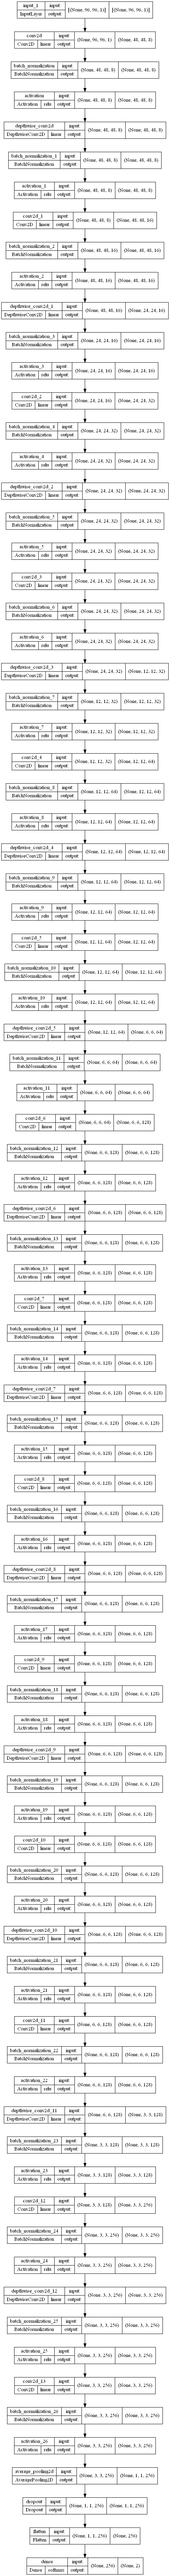

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True, rankdir='TB',show_layer_activations=True,show_layer_names=True,)

### Training the model

In [ ]:
### train_vww.py
"""Training for the visual wakewords person detection model.

The visual wakewords person detection model is a core model for the TinyMLPerf
benchmark suite. This script provides source for how the reference model was
created and trained, and can be used as a starting point for open submissions
using re-training.
"""



# model.summary()

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=.1,
    horizontal_flip=True,
    validation_split=validation_split,
    rescale=1. / 255)
train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    color_mode='grayscale') # was 'rgb'
val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    color_mode='grayscale') # was 'rgb'
print(train_generator.class_indices)


def train_epochs(model, train_generator, val_generator, epoch_count,
                 learning_rate, steps_per_epoch=None):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  if steps_per_epoch is None:
    steps_per_epoch = len(train_generator)
  history_fine = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epoch_count,
      validation_data=val_generator,
      validation_steps=len(val_generator),
      batch_size=BATCH_SIZE)
  return model

model = train_epochs(model, train_generator, val_generator, epochs[0], lrates[0])# steps_per_epoch=10)
model = train_epochs(model, train_generator, val_generator, epochs[1], lrates[1])
model = train_epochs(model, train_generator, val_generator, epochs[2], lrates[2])

model.save('vww_96_tmp_res.h5')


In [ ]:
save_model()

In [ ]:
model = train_epochs(model, train_generator, val_generator, epochs[2], lrates[2]/2)

In [ ]:
save_model()

In [ ]:
val_loss, val_acc = model.evaluate(val_generator, verbose=2)

In [ ]:
model.summary()

### Quantizing the model

In [ ]:
### From convert_vww.py

# model = tf.keras.models.load_model(argv[1])
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# with tf.io.gfile.GFile('vww_96_float.tflite', 'wb') as float_file:
#   float_file.write(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  dataset_dir = os.path.join(BASE_DIR, "person")
  for idx, image_file in enumerate(os.listdir(dataset_dir)):
    # 10 representative images should be enough for calibration.
    if idx > 10000:
        return
    full_path = os.path.join(dataset_dir, image_file)
    if os.path.isfile(full_path):
      img = tf.keras.preprocessing.image.load_img(
          full_path, color_mode=color_mode).resize((96, 96))
      arr = tf.keras.preprocessing.image.img_to_array(img)
      # Scale input to [0, 1.0] like in training.
      yield [arr.reshape(1, 96, 96, n_color_chans) / 255.] 

# Convert model to full-int8 and save as quantized tflite flatbuffer.
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quantized_tflite_model = converter.convert()
with tf.io.gfile.GFile('vww_96_int8test2.tflite', 'wb') as quantized_file:
    quantized_file.write(quantized_tflite_model)




In [ ]:
tf.lite.experimental.Analyzer.analyze(model_content=quantized_tflite_model)

### Testing single Images

In [ ]:
# rebuild the val-set generator with batch-size = 1
val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    subset='validation',
    color_mode='grayscale')

In [ ]:
b = val_generator.next()

In [ ]:
b[1].shape

In [ ]:
plt.imshow(-b[0][0,:,:,0], cmap='Greys')
print(b[1])

In [ ]:
x1=tf.keras.utils.load_img(
    path='data/train/p/person/30000.jpeg',
    color_mode="grayscale",
    target_size=(IMG_SIZE,IMG_SIZE),
    interpolation='nearest'
)

In [ ]:
x2=tf.keras.utils.load_img(
    path='data/train/n/notperson/30000.jpeg',
    color_mode="grayscale",
    target_size=(IMG_SIZE,IMG_SIZE),
    interpolation='nearest'
)

In [ ]:
x1_arr=tf.keras.utils.img_to_array(x1)
x1_shape=x1_arr.reshape((1,) +x1_arr.shape)
x1_predict=model.predict(x1_shape)
x1_predict

In [ ]:
x2_arr=tf.keras.utils.img_to_array(x2)
x2_shape=x2_arr.reshape((1,) +x2_arr.shape)
x2_predict=model.predict(x2_shape)
x2_predict